# Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

import gensim

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense, Conv2D, MaxPooling2D, Reshape, Lambda, Permute
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.backend import clear_session
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# Loading and Discovering the Dataset

In [73]:
url = 'https://raw.githubusercontent.com/Hala-Mulki/L-HSAB-First-Arabic-Levantine-HateSpeech-Dataset/master/Dataset/L-HSAB'
lhsab = pd.read_csv(url, sep='\t')

In [5]:
lhsab.head(10)

,Tweet,Class
0,الوزير جبران باسيل تاج راسك يا جربان ممنوع بعد...,abusive
1,صديقي انت ابن جامعه اللعبه اكبر من داعش اللعبه...,normal
2,و مصلحة لبنان تبدأ باستخراج النفط و الغاز لوقف...,normal
3,وليد جنبلاط كاتب الحكمة يا قذر,abusive
4,شو بتلبقلك كلمة خنزير بتجي مفصله على قياسك وشك...,abusive
5,يا جبران باسيل يا معلم يا ريس يا استاذ بدك حضن...,normal
6,ما سمعنا جعاركم مبارح على القصف الإسرائيلي يلي...,hate
7,نصيحة احكي مع الرئيس ميشال عون او هاجم جبران ب...,normal
8,صافي يا بقر,abusive
9,لا تعتب عليه هيدا اسمه ابو صرماي,abusive


In [6]:
lhsab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5846 entries, 0 to 5845
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   5846 non-null   object
 1   Class   5846 non-null   object
dtypes: object(2)
memory usage: 91.5+ KB


In [7]:
lhsab['Class'].value_counts()

normal     3650
abusive    1728
hate        468
Name: Class, dtype: int64

# Data Preparation/Preprocessing

In [56]:
# stops = set(stopwords.words("arabic"))

# stop_word_comp = {"،","آض","آمينَ","آه","آهاً","آي","أ","أب","أجل","أجمع","أخ","أخذ","أصبح","أضحى","أقبل","أقل","أكثر","ألا","أم","أما","أمامك","أمامكَ","أمسى","أمّا","أن","أنا","أنت","أنتم","أنتما","أنتن","أنتِ","أنشأ","أنّى","أو","أوشك","أولئك","أولئكم","أولاء","أولالك","أوّهْ","أي","أيا","أين","أينما","أيّ","أَنَّ","أََيُّ","أُفٍّ","إذ","إذا","إذاً","إذما","إذن","إلى","إليكم","إليكما","إليكنّ","إليكَ","إلَيْكَ","إلّا","إمّا","إن","إنّما","إي","إياك","إياكم","إياكما","إياكن","إيانا","إياه","إياها","إياهم","إياهما","إياهن","إياي","إيهٍ","إِنَّ","ا","ابتدأ","اثر","اجل","احد","اخرى","اخلولق","اذا","اربعة","ارتدّ","استحال","اطار","اعادة","اعلنت","اف","اكثر","اكد","الألاء","الألى","الا","الاخيرة","الان","الاول","الاولى","التى","التي","الثاني","الثانية","الذاتي","الذى","الذي","الذين","السابق","الف","اللائي","اللاتي","اللتان","اللتيا","اللتين","اللذان","اللذين","اللواتي","الماضي","المقبل","الوقت","الى","اليوم","اما","امام","امس","ان","انبرى","انقلب","انه","انها","او","اول","اي","ايار","ايام","ايضا","ب","بات","باسم","بان","بخٍ","برس","بسبب","بسّ","بشكل","بضع","بطآن","بعد","بعض","بك","بكم","بكما","بكن","بل","بلى","بما","بماذا","بمن","بن","بنا","به","بها","بي","بيد","بين","بَسْ","بَلْهَ","بِئْسَ","تانِ","تانِك","تبدّل","تجاه","تحوّل","تلقاء","تلك","تلكم","تلكما","تم","تينك","تَيْنِ","تِه","تِي","ثلاثة","ثم","ثمّ","ثمّة","ثُمَّ","جعل","جلل","جميع","جير","حار","حاشا","حاليا","حاي","حتى","حرى","حسب","حم","حوالى","حول","حيث","حيثما","حين","حيَّ","حَبَّذَا","حَتَّى","حَذارِ","خلا","خلال","دون","دونك","ذا","ذات","ذاك","ذانك","ذانِ","ذلك","ذلكم","ذلكما","ذلكن","ذو","ذوا","ذواتا","ذواتي","ذيت","ذينك","ذَيْنِ","ذِه","ذِي","راح","رجع","رويدك","ريث","رُبَّ","زيارة","سبحان","سرعان","سنة","سنوات","سوف","سوى","سَاءَ","سَاءَمَا","شبه","شخصا","شرع","شَتَّانَ","صار","صباح","صفر","صهٍ","صهْ","ضد","ضمن","طاق","طالما","طفق","طَق","ظلّ","عاد","عام","عاما","عامة","عدا","عدة","عدد","عدم","عسى","عشر","عشرة","علق","على","عليك","عليه","عليها","علًّ","عن","عند","عندما","عوض","عين","عَدَسْ","عَمَّا","غدا","غير","ـ","ف","فان","فلان","فو","فى","في","فيم","فيما","فيه","فيها","قال","قام","قبل","قد","قطّ","قلما","قوة","كأنّما","كأين","كأيّ","كأيّن","كاد","كان","كانت","كذا","كذلك","كرب","كل","كلا","كلاهما","كلتا","كلم","كليكما","كليهما","كلّما","كلَّا","كم","كما","كي","كيت","كيف","كيفما","كَأَنَّ","كِخ","لئن","لا","لات","لاسيما","لدن","لدى","لعمر","لقاء","لك","لكم","لكما","لكن","لكنَّما","لكي","لكيلا","للامم","لم","لما","لمّا","لن","لنا","له","لها","لو","لوكالة","لولا","لوما","لي","لَسْتَ","لَسْتُ","لَسْتُم","لَسْتُمَا","لَسْتُنَّ","لَسْتِ","لَسْنَ","لَعَلَّ","لَكِنَّ","لَيْتَ","لَيْسَ","لَيْسَا","لَيْسَتَا","لَيْسَتْ","لَيْسُوا","لَِسْنَا","ما","ماانفك","مابرح","مادام","ماذا","مازال","مافتئ","مايو","متى","مثل","مذ","مساء","مع","معاذ","مقابل","مكانكم","مكانكما","مكانكنّ","مكانَك","مليار","مليون","مما","ممن","من","منذ","منها","مه","مهما","مَنْ","مِن","نحن","نحو","نعم","نفس","نفسه","نهاية","نَخْ","نِعِمّا","نِعْمَ","ها","هاؤم","هاكَ","هاهنا","هبّ","هذا","هذه","هكذا","هل","هلمَّ","هلّا","هم","هما","هن","هنا","هناك","هنالك","هو","هي","هيا","هيت","هيّا","هَؤلاء","هَاتانِ","هَاتَيْنِ","هَاتِه","هَاتِي","هَجْ","هَذا","هَذانِ","هَذَيْنِ","هَذِه","هَذِي","هَيْهَاتَ","و","و6","وا","واحد","واضاف","واضافت","واكد","وان","واهاً","واوضح","وراءَك","وفي","وقال","وقالت","وقد","وقف","وكان","وكانت","ولا","ولم","ومن","مَن","وهو","وهي","ويكأنّ","وَيْ","وُشْكَانََ","يكون","يمكن","يوم","ّأيّان"}

In [57]:
# def tokenize_text(text):
#     tokens = word_tokenize(text) 
#     tokens = [token.strip() for token in tokens]
#     return tokens

# def remove_stopwords(text):
#     tokens = tokenize_text(text)
#     filtered_tokens = [token for token in tokens if token not in stops and token not in stop_word_comp]
#     filtered_text = ' '.join(filtered_tokens)    
#     return filtered_text

In [58]:
# lhsab['Tweet'] = lhsab['Tweet'].apply(lambda x:remove_stopwords(x))

In [74]:
def clean_text(tweet):
    #remove emoji
    emoji = re.compile("["
                        u'\U0001F600-\U0001F64F'  # emoticons
                        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
                        u'\U0001F680-\U0001F6FF'  # transport & map symbols
                        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
                        u'\U00002702-\U000027B0'
                        u'\U000024C2-\U0001F251'
                        "]+", flags=re.UNICODE)
    tweet = emoji.sub(r'', tweet)

    #remove punctuation
    punctuation = '''!\(\)-\[]\{};:'"\,<>./?@#$%^&*_~=+…''' + u'\u060C' + u'\u061B' + u'\u061F'
    for c in tweet:
        if c in punctuation:
            tweet = tweet.replace(c, '')

    #remove laughter
    laughter = re.compile(r'\b(ه|خ)\1{2,}\b')
    tweet = laughter.sub('', tweet)

    #remove nonsense
    nonsense = re.compile(r'\b(.)\1{2,}\b')
    tweet = nonsense.sub(r'', tweet)

    tweet = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', tweet)  # remove punctuation
    tweet = re.sub('\s+', ' ', tweet)  
    tweet = re.sub("\d+", " ", tweet)
    tweet = re.sub('\W+', ' ', tweet)
    tweet = re.sub('[A-Za-z]+',' ',tweet)
    tweet = re.sub(r'\\u[A-Za-z0-9\\]+',' ',tweet)
    tweet = re.sub('\s+', ' ', tweet)  

    emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   "]+", flags=re.UNICODE)
    tweet = emoji_pattern.sub(r'', tweet)

    #normalize elongated words
    repeated_characters = re.compile(r'(.)\1{2,}')
    tweet = repeated_characters.sub(r'\1', tweet)

    return tweet

clean_text = np.vectorize(clean_text)

In [75]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 280

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=False)
tokenizer.fit_on_texts(clean_text(lhsab['Tweet'].values))
VOCAB_SIZE = len(tokenizer.word_index) + 1
word_list = list(tokenizer.word_index.keys())

X = tokenizer.texts_to_sequences(clean_text(lhsab['Tweet'].values))
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

y = pd.get_dummies(lhsab['Class'].values)
label_names = y.columns
y = y.values

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4676, 280) (4676, 3)
(1170, 280) (1170, 3)


In [11]:
print(word_list)

['يا', 'من', 'جبران', 'ما', 'باسيل', 'و', 'في', 'على', 'انت', 'لا', 'شو', 'بس', 'الله', 'كل', 'عن', 'عم', 'لبنان', 'مش', 'مع', 'ولا', 'هوا', 'وهاب', 'كول', 'هو', 'شي', 'ان', 'كان', 'قطر', 'اذا', 'الوزير', 'ع', 'كلب', 'لو', 'هذا', 'يلي', 'مين', 'واحد', 'هيك', 'متل', 'انو', 'سوريا', 'وئام', 'الى', 'أن', 'عليك', 'وزير', 'حدا', 'والله', 'او', 'روح', 'الرئيس', 'هيدا', 'اللي', 'بعد', 'بدك', 'بلا', 'هل', 'انا', 'كيف', 'عون', 'دولة', 'عثمان', 'يعني', 'لك', 'ابو', 'غير', 'الا', 'لازم', 'قال', 'منك', 'رح', 'كنت', 'حق', 'وما', 'حمار', 'قبل', 'ابن', 'إلى', 'العربية', 'لي', 'ل', 'بشار', 'وانت', 'القمة', 'انك', 'هي', 'الحريري', 'حتى', 'أو', 'الخارجية', 'ب', 'اسرائيل', 'تحكي', 'ولك', 'البلد', 'وين', 'خراس', 'السيد', 'معالي', 'رئيس', 'لما', 'فيه', 'سعد', 'الناس', 'بدو', 'حالك', 'الحق', 'صار', 'ليش', 'يلعن', 'حزب', 'معك', 'الي', 'يكون', 'شيخ', 'كتير', 'العرب', 'فيك', 'حسن', 'كلاب', 'لم', 'طيب', 'انه', 'الدولة', 'قاتل', 'يوم', 'عنا', 'راسك', 'وليد', 'شعب', 'تكون', 'عند', 'مثل', 'الذي', 'كلام', 'الشيخ', 

# Loading AraVec

In [77]:
aravec = gensim.models.Word2Vec.load('/content/drive/MyDrive/tweets_sg_100/tweets_sg_100')

embedding_matrix = np.zeros((VOCAB_SIZE, 100))
for word, i in tokenizer.word_index.items():
    if word in aravec.wv.vocab:
        embedding_matrix[i] = aravec.wv.word_vec(word)

In [ ]:
aravec.wv.most_similar('غبي')

[('وغبي', 0.8386841416358948),
 ('اهبل', 0.823290228843689),
 ('ذكي', 0.793826699256897),
 ('ساذج', 0.7756971120834351),
 ('دلخ', 0.7637712359428406),
 ('فاشل', 0.7495485544204712),
 ('وتافه', 0.7489588260650635),
 ('وقح', 0.7488861083984375),
 ('بجيح', 0.7456430792808533),
 ('ومتخلف', 0.7448433637619019)]

In [ ]:
aravec.wv.most_similar('عاهر')

[('داعر', 0.7564408779144287),
 ('معتوه', 0.747181236743927),
 ('منحط', 0.7423575520515442),
 ('ومنافق', 0.7298714518547058),
 ('نجس', 0.728484034538269),
 ('شاذ', 0.7253782153129578),
 ('ومتخلف', 0.7215023040771484),
 ('ومنحط', 0.7192544937133789),
 ('زنديق', 0.7085251808166504),
 ('خسيس', 0.6997836232185364)]

In [ ]:
aravec.wv.most_similar('بهيم')

[('بغل', 0.6742550730705261),
 ('هبيله', 0.6707864999771118),
 ('ومعرص', 0.6680583953857422),
 ('مخو', 0.6537748575210571),
 ('قذافي', 0.644923746585846),
 ('زلمي', 0.6406307220458984),
 ('شادها', 0.6402127742767334),
 ('زلمه', 0.6397022604942322),
 ('ماكش', 0.6361751556396484),
 ('اهبل', 0.6354578137397766)]

In [ ]:
aravec.wv.most_similar('تيار')

[('وتيار', 0.7635721564292908),
 ('تكتل', 0.7617678642272949),
 ('التقدمي', 0.7359667420387268),
 ('انتخابي', 0.7192368507385254),
 ('فصيل', 0.7143242359161377),
 ('الاصلاح', 0.7101719379425049),
 ('سياسي', 0.7094211578369141),
 ('والاصلاح', 0.709301233291626),
 ('ايديولوجي', 0.7088208794593811),
 ('لتيار', 0.7064974904060364)]

In [ ]:
aravec.wv.most_similar('داعش')

[('الصحوات', 0.8500247597694397),
 ('الدواعش', 0.8475117683410645),
 ('النصره', 0.8457817435264587),
 ('المليشيات', 0.8329477906227112),
 ('داعش»', 0.831871747970581),
 ('الارهابين', 0.8304831981658936),
 ('تنظيم', 0.8277500867843628),
 ('الفلوجه', 0.8274105787277222),
 ('دواعش', 0.8157409429550171),
 ('الحشد', 0.8132305145263672)]

---

# Bidirectional LSTM

In [ ]:
EMBEDDING_DIM = 100

def create_model(dropout_rate=0.8, lstm_dropout=0.2, nb_lstm=2, lstm_units=16, dense_units=16, nb_dense=0):
    clear_session()
    model = Sequential()
    model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
    model.add(Dropout(dropout_rate))
    for i in range(nb_lstm):
        model.add(Bidirectional(LSTM(lstm_units , dropout=lstm_dropout, return_sequences=True)))
        model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(lstm_units, dropout=lstm_dropout, return_sequences=False)))
    model.add(Dropout(dropout_rate))
    for i in range(nb_dense):
        model.add(Dense(dense_units, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = KerasClassifier(build_fn=create_model)

In [ ]:
parameters = {
    'dropout_rate' : [0.2, 0.5, 0.8],
    'lstm_dropout' : [0.2, 0.5, 0.8],
    'nb_lstm' : [1, 2, 3, 4],
    'lstm_units' : [8, 16, 32],
    'dense_units' : [8, 16, 32],
    'nb_dense' : [0, 1, 2],
    'batch_size' : [100, 500, 1000],
    'epochs' : [20, 40, 60]
}

clf = RandomizedSearchCV(estimator=model, param_distributions=parameters, random_state=29)

In [ ]:
class_weights = compute_class_weight('balanced', np.unique(np.argmax(y_train, axis=1)), np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))

In [ ]:
clf.fit(X_train, y_train, class_weight=class_weights, verbose=0)

In [ ]:
print(f"best score is {clf.best_score_}, best parameter from grid search is{clf.best_params_}")

best score is 0.7290417909622192, best parameter from grid search is{'nb_lstm': 1, 'nb_dense': 0, 'lstm_units': 8, 'lstm_dropout': 0.2, 'epochs': 60, 'dropout_rate': 0.8, 'dense_units': 8, 'batch_size': 100}


In [ ]:
bilstm_cv = load_model('/content/drive/My Drive/Neural Networks Project/bilstm_cv.h5')
bilstm_cv.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 280, 100)          2094700   
_________________________________________________________________
dropout (Dropout)            (None, 280, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 280, 16)           6976      
_________________________________________________________________
dropout_1 (Dropout)          (None, 280, 16)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16)                1600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 5

In [ ]:
y_pred = np.argmax(bilstm_cv.predict(X_test, batch_size=1), axis=1)
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=label_names))

              precision    recall  f1-score   support

     abusive       0.65      0.63      0.64       346
        hate       0.40      0.52      0.45        94
      normal       0.82      0.80      0.81       730

    accuracy                           0.72      1170
   macro avg       0.62      0.65      0.63      1170
weighted avg       0.73      0.72      0.73      1170



---

# Bidirectional LSTM with AraVec CV

In [78]:
EMBEDDING_DIM = 100
EPOCHS = 60
BATCH = 100

#clear_session()
bilstm_aravec_cv = Sequential()
bilstm_aravec_cv.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=True))
bilstm_aravec_cv.add(Dropout(0.8))
bilstm_aravec_cv.add(Bidirectional(LSTM(8, dropout=0.2, return_sequences=False)))
bilstm_aravec_cv.add(Dropout(0.8))
bilstm_aravec_cv.add(Dense(3, activation='softmax'))

bilstm_aravec_cv.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [79]:
bilstm_aravec_cv.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 280, 100)          2073400   
_________________________________________________________________
dropout_4 (Dropout)          (None, 280, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16)                6976      
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 51        
Total params: 2,080,427
Trainable params: 2,080,427
Non-trainable params: 0
_________________________________________________________________


In [80]:
class_weights = compute_class_weight('balanced', np.unique(np.argmax(y_train, axis=1)), np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))

In [81]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/bilstm_aravec_cv.h5', monitor='val_loss', verbose=0, save_best_only=True)

In [82]:
history = bilstm_aravec_cv.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH, validation_split=0.2, class_weight=class_weights, callbacks=[checkpoint])

Epoch 1/60
38/38 [==============================] - 5s 64ms/step - loss: 1.0912 - accuracy: 0.4186 - val_loss: 1.0752 - val_accuracy: 0.4893
Epoch 2/60
38/38 [==============================] - 2s 44ms/step - loss: 1.1323 - accuracy: 0.3514 - val_loss: 1.0677 - val_accuracy: 0.5182
Epoch 3/60
38/38 [==============================] - 2s 44ms/step - loss: 1.1046 - accuracy: 0.3836 - val_loss: 1.0597 - val_accuracy: 0.5620
Epoch 4/60
38/38 [==============================] - 2s 45ms/step - loss: 1.0941 - accuracy: 0.4108 - val_loss: 1.0643 - val_accuracy: 0.5192
Epoch 5/60
38/38 [==============================] - 2s 44ms/step - loss: 1.0878 - accuracy: 0.4099 - val_loss: 1.0555 - val_accuracy: 0.5556
Epoch 6/60
38/38 [==============================] - 2s 44ms/step - loss: 1.1017 - accuracy: 0.4054 - val_loss: 1.0497 - val_accuracy: 0.5694
Epoch 7/60
38/38 [==============================] - 2s 45ms/step - loss: 1.0785 - accuracy: 0.4139 - val_loss: 1.0391 - val_accuracy: 0.5972
Epoch 8/60
38

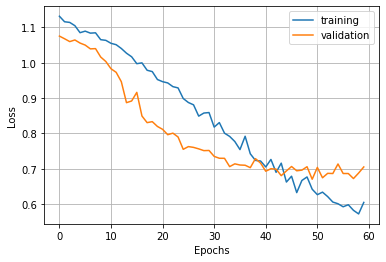

In [83]:
plt.figure()
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [84]:
bilstm_aravec_cv = load_model('/content/drive/MyDrive/bilstm_aravec_cv.h5')
y_pred = np.argmax(bilstm_aravec_cv.predict(X_test, batch_size=1), axis=1)
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=label_names))

              precision    recall  f1-score   support

     abusive       0.66      0.64      0.65       346
        hate       0.45      0.48      0.46        94
      normal       0.85      0.85      0.85       730

    accuracy                           0.76      1170
   macro avg       0.65      0.66      0.66      1170
weighted avg       0.76      0.76      0.76      1170



# CNN-LSTM

In [85]:
#Tunable (These values are after tuning)
dropout_rate = 0.8
lstm_dropout = 0.7
lstm_units = 20
nb_filters = 64
filter_size = 3

e = 20
batch_size = 256

#Architecture
EMBEDDING_DIM = 100
clear_session()
model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix]))
model.add(Permute((2,1), input_shape = (MAX_SEQUENCE_LENGTH, EMBEDDING_DIM)))
model.add(Lambda(lambda t: t[..., None]))
model.add(Conv2D(nb_filters, (100,filter_size), input_shape=(EMBEDDING_DIM, MAX_SEQUENCE_LENGTH, 1), name = 'Conv'))
model.add(MaxPooling2D(pool_size= model.get_layer('Conv').output_shape[1:3]))
model.add(Dropout(dropout_rate))
model.add(Reshape((1, nb_filters)))
model.add(LSTM(lstm_units, return_sequences=False))
model.add(Dropout(lstm_dropout))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [86]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 280, 100)          2073400   
_________________________________________________________________
permute (Permute)            (None, 100, 280)          0         
_________________________________________________________________
lambda (Lambda)              (None, 100, 280, 1)       0         
_________________________________________________________________
Conv (Conv2D)                (None, 1, 278, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 64)          0         
_________________________________________________________________
reshape (Reshape)            (None, 1, 64)             0

In [87]:
class_weights = compute_class_weight('balanced', np.unique(np.argmax(y_train, axis=1)), np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))

In [88]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/cnn_lstm.h5', monitor='val_loss', verbose=0, save_best_only=True)

In [89]:
history = model.fit(X_train, y_train, class_weight=class_weights, validation_split=0.2, epochs = e, batch_size = batch_size, callbacks=[checkpoint])

Epoch 1/20
15/15 [==============================] - 14s 815ms/step - loss: 1.1027 - accuracy: 0.3349 - val_loss: 1.0765 - val_accuracy: 0.6549
Epoch 2/20
15/15 [==============================] - 12s 794ms/step - loss: 1.0964 - accuracy: 0.3687 - val_loss: 1.0669 - val_accuracy: 0.5780
Epoch 3/20
15/15 [==============================] - 12s 799ms/step - loss: 1.0764 - accuracy: 0.4122 - val_loss: 1.0325 - val_accuracy: 0.6442
Epoch 4/20
15/15 [==============================] - 12s 806ms/step - loss: 1.0502 - accuracy: 0.4848 - val_loss: 0.9974 - val_accuracy: 0.6432
Epoch 5/20
15/15 [==============================] - 12s 809ms/step - loss: 0.9722 - accuracy: 0.4987 - val_loss: 0.9558 - val_accuracy: 0.6400
Epoch 6/20
15/15 [==============================] - 12s 814ms/step - loss: 1.0231 - accuracy: 0.5176 - val_loss: 0.9434 - val_accuracy: 0.5908
Epoch 7/20
15/15 [==============================] - 12s 816ms/step - loss: 0.9620 - accuracy: 0.5451 - val_loss: 0.8974 - val_accuracy: 0.6389

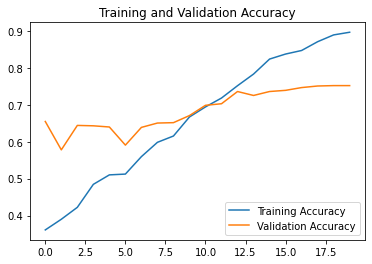

In [93]:
epochs_range = range(e)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

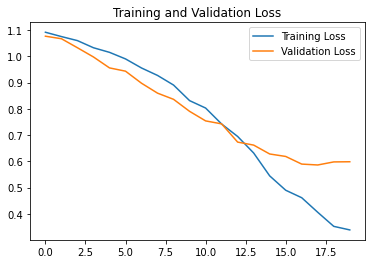

In [94]:
epochs_range = range(e)

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [96]:
y_pred = np.argmax(model.predict(X_test, batch_size=1), axis=1)

print('Confusion Matrix')
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

Confusion Matrix
[[238  54  54]
 [ 26  54  14]
 [ 85  52 593]]


In [97]:
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=label_names))

              precision    recall  f1-score   support

     abusive       0.68      0.69      0.68       346
        hate       0.34      0.57      0.43        94
      normal       0.90      0.81      0.85       730

    accuracy                           0.76      1170
   macro avg       0.64      0.69      0.65      1170
weighted avg       0.79      0.76      0.77      1170

